In [1]:
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

2022-01-25 12:11:31.784839: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 7584240340546984913,
 name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 32002277376
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 1979500761110525440
 physical_device_desc: "device: 0, name: Tesla V100S-PCIE-32GB, pci bus id: 0000:3b:00.0, compute capability: 7.0"]

2022-01-25 12:11:32.586394: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1510] Created device /device:GPU:0 with 30519 MB memory:  -> device: 0, name: Tesla V100S-PCIE-32GB, pci bus id: 0000:3b:00.0, compute capability: 7.0


In [2]:
import os
print(os.listdir('./data/flowers'))

['dandelion', 'daisy', 'sunflower', 'tulip', 'rose']


In [3]:
# GPU 관련
import os
import tensorflow as tf

In [4]:
# warnings 처리를 위함
import warnings
warnings.filterwarnings('always')
warnings.filterwarnings('ignore')

In [5]:
# 데이터 시각화를 위함
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import style
import seaborn as sns

In [6]:
# model selection
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import accuracy_score, precision_recall_curve, recall_score, confusion_matrix, roc_auc_score, roc_curve
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import LabelEncoder

In [7]:
# preprocess
from tensorflow.python.keras.preprocessing.image import ImageDataGenerator

In [8]:
# keras 관련 라이브러리
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import backend as K
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam, SGD, Adagrad, Adadelta, RMSprop
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import classification_report, log_loss, accuracy_score
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import random, PIL

In [9]:
# CNN 관련 모듈
from tensorflow.keras.layers import Dropout, Flatten, Activation
from tensorflow.keras.layers import Conv2D, MaxPooling2D, BatchNormalization

In [10]:
batch_size = 32
img_height = 224
img_width = 224

In [11]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  './data/flowers',
  validation_split = 0.2,
  subset = "training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 4317 files belonging to 5 classes.
Using 3454 files for training.


2022-01-25 12:11:35.039363: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1510] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 30519 MB memory:  -> device: 0, name: Tesla V100S-PCIE-32GB, pci bus id: 0000:3b:00.0, compute capability: 7.0


In [12]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  './data/flowers',
  validation_split = 0.2,
  subset = "validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 4317 files belonging to 5 classes.
Using 863 files for validation.


In [13]:
class_names = train_ds.class_names

2022-01-25 12:11:35.899877: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


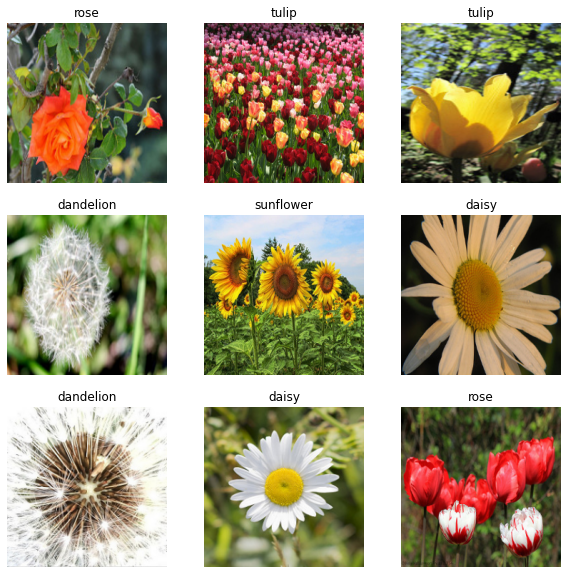

In [14]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [15]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 224, 224, 3)
(32,)


In [16]:
size = (224, 224)

train_ds = train_ds.map(lambda x, y: (tf.image.resize(x, size), y))
validation_ds = val_ds.map(lambda x, y: (tf.image.resize(x, size), y))

In [17]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)

In [18]:
data_augmentation = keras.Sequential(
  [
    layers.experimental.preprocessing.RandomFlip("horizontal", 
                                                 input_shape=(img_height, 
                                                              img_width,
                                                              3)),
    layers.experimental.preprocessing.RandomRotation(0.1),
    layers.experimental.preprocessing.RandomZoom(0.1),
  ]
)

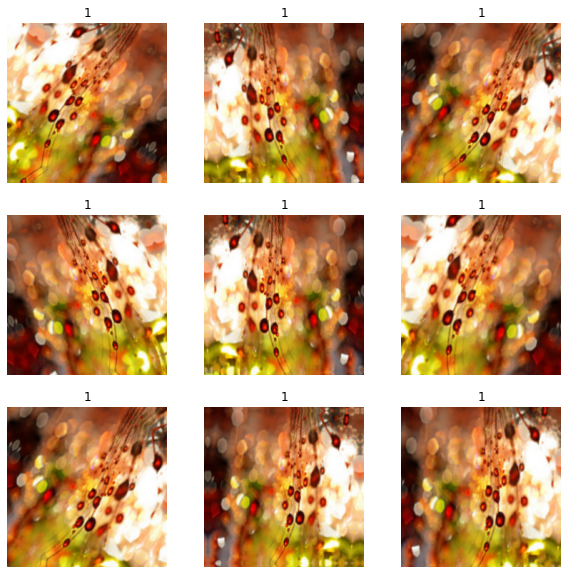

In [19]:
import numpy as np

for images, labels in train_ds.take(1):
    plt.figure(figsize=(10, 10))
    first_image = images[0]
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        augmented_image = data_augmentation(
            tf.expand_dims(first_image, 0), training=True
        )
        plt.imshow(augmented_image[0].numpy().astype("uint8"))
        plt.title(int(labels[0]))
        plt.axis("off")

In [20]:
from keras.applications.vgg19 import VGG19
from keras.layers import GlobalAveragePooling2D

base_model = VGG19(input_shape=(img_width, img_height, 3), 
                   include_top=False, 
                   weights='imagenet')

base_model.trainable=False

In [27]:
VGGmodel = tf.keras.Sequential([
  base_model,
  MaxPooling2D((2, 2), strides = 2),
  Flatten(),
  Dense(5, activation="softmax")
])

In [28]:
opt = Adam(lr=0.001)
VGGmodel.compile(loss="sparse_categorical_crossentropy", optimizer=opt, metrics=['accuracy'])

In [29]:
VGGmodel.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg19 (Functional)           (None, 7, 7, 512)         20024384  
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 3, 3, 512)         0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 4608)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 5)                 23045     
Total params: 20,047,429
Trainable params: 23,045
Non-trainable params: 20,024,384
_________________________________________________________________


In [30]:
from keras.callbacks import EarlyStopping , ReduceLROnPlateau

learning_rate_reduction=ReduceLROnPlateau(monitor="val_loss",
                                          patience=3,
                                          factor = 0.5,
                                          min_lr=0.00001,
                                          verbose=1)

earlystop = EarlyStopping(patience=10)

checkpoint_path = "training/cpFalse.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=1)

callbacks = [earlystop, learning_rate_reduction, cp_callback]

In [31]:
history = VGGmodel.fit(
                        train_ds,
                        validation_data=val_ds,
                        epochs=50,
                        callbacks=[callbacks]
                                              )

Epoch 1/50


2022-01-25 12:17:54.890705: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8201


108/108 [==============================] - 14s 104ms/step - loss: 6.0357 - accuracy: 0.6908 - val_loss: 4.8654 - val_accuracy: 0.7740

Epoch 00001: saving model to training/cpFalse.ckpt
Epoch 2/50
108/108 [==============================] - 7s 65ms/step - loss: 1.7549 - accuracy: 0.8631 - val_loss: 4.9976 - val_accuracy: 0.7775

Epoch 00002: saving model to training/cpFalse.ckpt
Epoch 3/50
108/108 [==============================] - 7s 65ms/step - loss: 0.6404 - accuracy: 0.9218 - val_loss: 5.2728 - val_accuracy: 0.7822

Epoch 00003: saving model to training/cpFalse.ckpt
Epoch 4/50
108/108 [==============================] - 7s 64ms/step - loss: 0.3015 - accuracy: 0.9595 - val_loss: 5.0190 - val_accuracy: 0.7729

Epoch 00004: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.

Epoch 00004: saving model to training/cpFalse.ckpt
Epoch 5/50
108/108 [==============================] - 7s 64ms/step - loss: 0.1340 - accuracy: 0.9789 - val_loss: 4.7418 - val_accuracy: 0.7856

Epoc

In [32]:
VGGmodel.save('using_VGG19_whole.h5')
VGGmodel.save_weights('using_VGG19_weights.h5')

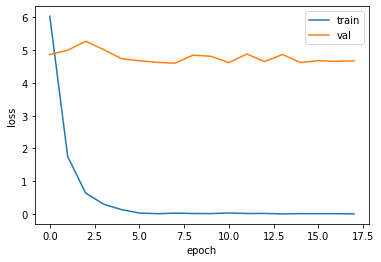

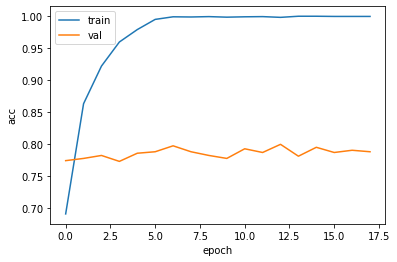

In [34]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train','val'])
plt.show()

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.xlabel('epoch')
plt.ylabel('acc')
plt.legend(['train','val'])
plt.show()

In [35]:
test_image_path = './data/test/rose_test.png'
img = tf.keras.utils.load_img(
    test_image_path, grayscale=False, color_mode='rgb', target_size=(img_height, img_width),
    interpolation='nearest'
)
img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = VGGmodel.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "이 사진속 꽃은 {} 와 {:.2f} 퍼센트 일치합니다"
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

이 사진속 꽃은 rose 와 39.28 퍼센트 일치합니다


In [36]:
VGGmodel2 = tf.keras.Sequential([
  base_model,
  Flatten(),
  Dense(5, activation="softmax")
])

In [37]:
base_model.trainable=True
VGGmodel2.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg19 (Functional)           (None, 7, 7, 512)         20024384  
_________________________________________________________________
flatten_2 (Flatten)          (None, 25088)             0         
_________________________________________________________________
dense_2 (Dense)              (None, 5)                 125445    
Total params: 20,149,829
Trainable params: 20,149,829
Non-trainable params: 0
_________________________________________________________________


In [41]:
opt = Adam(lr=1e-5) # Low learning rate
VGGmodel2.compile(loss="sparse_categorical_crossentropy", optimizer=opt, metrics=['accuracy'])

In [42]:
from keras.callbacks import EarlyStopping , ReduceLROnPlateau

learning_rate_reduction=ReduceLROnPlateau(monitor="val_loss",
                                          patience=3,
                                          factor = 0.5,
                                          min_lr=0.0001,
                                          verbose=1)

earlystop = EarlyStopping(patience=10)

checkpoint_path = "training/cpTrue.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=1)

callbacks = [earlystop, learning_rate_reduction, cp_callback]

In [43]:
history = VGGmodel2.fit(
                        train_ds,
                        validation_data=val_ds,
                        epochs=50,
                        callbacks=[callbacks]
                                              )

Epoch 1/50
108/108 [==============================] - 25s 199ms/step - loss: 2.2198 - accuracy: 0.3602 - val_loss: 1.2422 - val_accuracy: 0.4936

Epoch 00001: saving model to training/cpTrue.ckpt
Epoch 2/50
108/108 [==============================] - 19s 172ms/step - loss: 0.8835 - accuracy: 0.6572 - val_loss: 0.8943 - val_accuracy: 0.6547

Epoch 00002: saving model to training/cpTrue.ckpt
Epoch 3/50
108/108 [==============================] - 18s 171ms/step - loss: 0.5144 - accuracy: 0.8089 - val_loss: 0.7697 - val_accuracy: 0.7184

Epoch 00003: saving model to training/cpTrue.ckpt
Epoch 4/50
108/108 [==============================] - 18s 170ms/step - loss: 0.3068 - accuracy: 0.8972 - val_loss: 0.7581 - val_accuracy: 0.7439

Epoch 00004: saving model to training/cpTrue.ckpt
Epoch 5/50
108/108 [==============================] - 18s 171ms/step - loss: 0.1627 - accuracy: 0.9534 - val_loss: 0.7581 - val_accuracy: 0.7636

Epoch 00005: saving model to training/cpTrue.ckpt
Epoch 6/50
108/108 [

In [44]:
VGGmodel2.save('using_VGG19_True_whole.h5')
VGGmodel2.save_weights('using_VGG19_True_weights.h5')

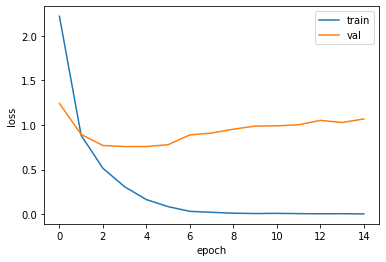

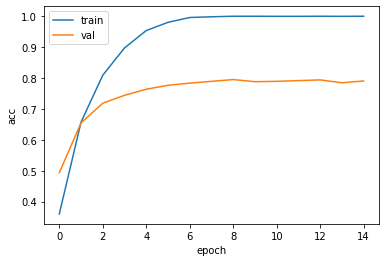

In [46]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train','val'])
plt.show()

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.xlabel('epoch')
plt.ylabel('acc')
plt.legend(['train','val'])
plt.show()

In [47]:
test_image_path = './data/test/rose_test.png'
img = tf.keras.utils.load_img(
    test_image_path, grayscale=False, color_mode='rgb', target_size=(img_height, img_width),
    interpolation='nearest'
)
img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = VGGmodel2.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "이 사진속 꽃은 {} 와 {:.2f} 퍼센트 일치합니다"
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

이 사진속 꽃은 rose 와 40.42 퍼센트 일치합니다
